In [2]:
%load_ext autoreload 
%autoreload 2 
import pandas as pd
import numpy as np
from scipy.stats import norm
from quantstats.stats import sharpe
import numpy as np
from numpy.core.numeric import normalize_axis_tuple
from numpy.core.overrides import array_function_dispatch, set_module
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns


In [ ]:

market_data = pd.read_parquet('data/US/test_mkt_data.pq')
earnings = pd.read_parquet('data/US/test_earnings.pq')
GICS = pd.read_parquet('data/US/test_GICS.pq')
P = pd.read_parquet('data/US/test_universe_table.pq')
P.index.names = ['Date']
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.dropna().sample(5)

In [45]:
from sklearn import preprocessing
# from sklearn.datasets import load_boston
import numpy as np

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])

def scale_features(data, axis:int=0,with_mean:bool = True, with_std:bool = True):
    """
    Scales the specified features of the dataset.

    Parameters:
    data (array-like): The dataset containing the features to be scaled.
    features (list or slice, optional): The indices or slice of the features to be scaled.
        If None, all features will be scaled.

    Returns:
    scaled_data (array-like): The dataset with the specified features scaled.
    original_means (array-like): The means of the original specified features.
    original_stds (array-like): The standard deviations of the original specified features.
    scaled_means (array-like): The means of the scaled specified features.
    scaled_stds (array-like): The standard deviations of the scaled specified features.
    """
    data_scaled = preprocessing.scale(data,axis=axis,with_mean= with_mean, with_std = with_std)
    return pd.DataFrame(data_scaled)


scale_features(raw_df,axis=1).mean(1)

0      -3.532528e-17
1      -7.401487e-17
2      -8.326673e-17
3       3.700743e-17
4      -4.541821e-17
            ...     
1007    1.110223e-16
1008   -2.018587e-17
1009   -1.480297e-16
1010   -5.046468e-17
1011    7.401487e-17
Length: 1012, dtype: float64

In [49]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

def scale_dataframe(df: pd.DataFrame, feature_columns: list = None):
    """
    Scales the specified columns of the dataframe using StandardScaler 
    
    Args:
    df (pd.DataFrame): The input dataframe containing the features to be scaled.
    feature_columns (list, optional): A list of column names to be scaled. If None, all columns will be scaled. Defaults to None.

    Returns:
    np.ndarray: The scaled features.
    """
    if feature_columns is None:
        feature_columns = df.columns.tolist()

    scaler = StandardScaler()
    scaler.fit(df[feature_columns])
    scaled_features = scaler.transform(df[feature_columns])
    return pd.DataFrame(scaled_features)

scale_dataframe(raw_df).std(0)

0     1.000494
1     1.000494
2     1.000494
3     1.000990
4     1.000990
5     1.000990
6     1.000990
7     1.000990
8     1.000990
9     1.000990
10    1.000990
dtype: float64

<Axes: ylabel='Frequency'>

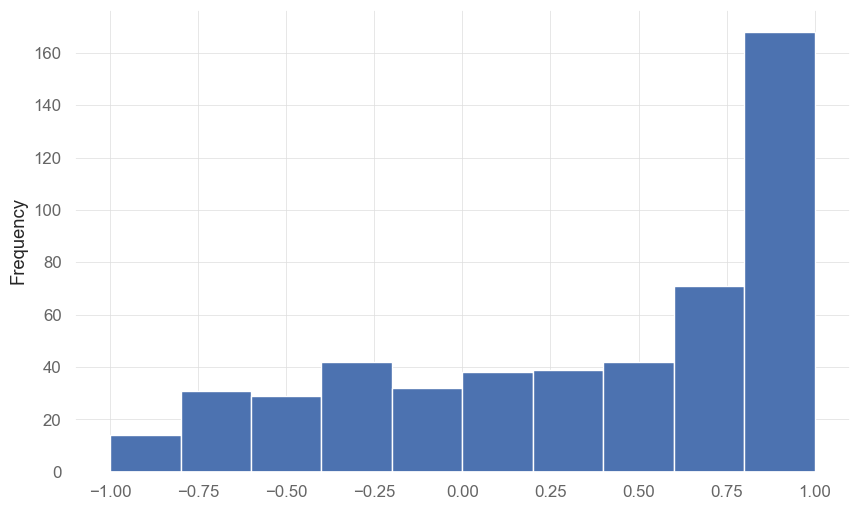

In [50]:
def minmax_scaler(df,feature_columns: list= None, min:float = 0.0,max: float = 1.0):
    
    """
    scales the specified columns of the dataframe using  
    MinMaxScaler and returns the mean or min/max of the scaled features.
    """
    
    scaler = preprocessing.MinMaxScaler(feature_range=(min,max))
    if feature_columns is None:
        feature_columns = df.columns.tolist()
    scaler.fit(df[feature_columns])
    scaled_features = scaler.transform(df[feature_columns])
    return pd.DataFrame(scaled_features)


minmax_scaler(raw_df,min = -1,max=1)[6].plot(kind = 'hist')



In [51]:
raw_df.isna().sum(0)

0       0
1       0
2       0
3     506
4     506
5     506
6     506
7     506
8     506
9     506
10    506
dtype: int64

In [63]:
X,y = raw_df.iloc[:,1:], raw_df.iloc[:,0]

from sklearn.preprocessing import Binarizer
import numpy as np
import pandas as pd

def binarize_data(y: pd.Series, threshold='mean'):
    """
    Binarizes the input data based on the specified threshold. If the value is greater than 
    the threshold, it produces a 1; otherwise, it produces a 0.

    Args:
    y (pd.Series): The input data to be binarized.
    threshold (float or str, optional): The threshold for binarization. If 'mean', the mean 
    of the data is used. If 'median', the median of the data is used. If a float is provided, 
    it is used as the threshold. Defaults to 'mean'.

    Returns:
    np.ndarray: The binarized data.
    """
    if threshold == 'mean':
        threshold_value = y.mean()
    elif threshold == 'median':
        threshold_value = y.median()
    elif isinstance(threshold, (int, float)):
        threshold_value = float(threshold)
    else:
        raise ValueError("threshold must be 'mean', 'median', or a float")

    binarizer = Binarizer(threshold=threshold_value)
    binarized_data = binarizer.fit_transform(y.values.reshape(-1, 1))

    return pd.DataFrame(binarized_data)

# Example usage:
# y = pd.Series([value1, value2, value3, ...])
binarized_mean = binarize_data(y)
binarized_median = binarize_data(y, threshold='median')
binarized_median


,0
0,0.0
1,1.0
2,0.0
3,1.0
4,0.0
...,...
1007,1.0
1008,0.0
1009,1.0
1010,0.0


In [72]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import datasets
import pandas as pd
import numpy as np

def encode_categorical_target(y: pd.Series) -> np.ndarray:
    """
    Encodes a categorical target variable using one-hot encoding.

    Args:
    y (pd.Series): The categorical target variable to be encoded.

    Returns:
    np.ndarray: The one-hot encoded target variable.
    """
    encoder = OneHotEncoder(sparse=False)
    encoded_target = encoder.fit_transform(y.values.reshape(-1, 1))
    return encoded_target

# Example usage:
# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = pd.Series(iris.target)

# Encode the categorical target
encoded_target = encode_categorical_target(y)
def create_train_test_splits(X: np.ndarray, y: pd.Series, test_size: float = 0.25, random_state: int = 7):
    """
    Creates training and testing sets with one-hot encoding for the target variable.

    Args:
    X (np.ndarray): The feature matrix.
    y (pd.Series): The categorical target variable.
    test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.25.
    random_state (int, optional): The random seed for reproducibility. Defaults to 7.

    Returns:
    tuple: The training and testing splits for features and target.
    """
    y_encoded = encode_categorical_target(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, stratify=y, random_state=random_state)
    return X_train, X_test, y_train, y_test


iris = datasets.load_iris()
X = iris.data
y = pd.Series(iris.target)

# Create training and testing sets
X_train, X_test, y_train, y_test = create_train_test_splits(X, y)
y_train

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0

In [76]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn import preprocessing
import numpy as np

def train_multioutput_ridge_regressor(X_train: np.ndarray, y_train: np.ndarray, alpha: float = 1.0, fit_intercept: bool = True):
    """
    Trains a MultiOutputRegressor using Ridge regression as the base estimator.

    Args:
    X_train (np.ndarray): The training feature matrix.
    y_train (np.ndarray): The multi-output target matrix.
    alpha (float, optional): Regularization strength for Ridge regression. Defaults to 1.0.
    fit_intercept (bool, optional): Whether to calculate the intercept for this model. Defaults to True.

    Returns:
    MultiOutputRegressor: The trained multi-output ridge regressor.
    """
    ridge = Ridge(alpha=alpha, fit_intercept=fit_intercept)
    multi_ridge = MultiOutputRegressor(ridge, n_jobs=-1)
    multi_ridge.fit(X_train, y_train)
    return multi_ridge

def predict_and_binarize(model: MultiOutputRegressor, X_test: np.ndarray, threshold: float = 0.5):
    """
    Predicts the multi-output target and binarizes the predictions.

    Args:
    model (MultiOutputRegressor): The trained multi-output ridge regressor.
    X_test (np.ndarray): The testing feature matrix.
    threshold (float, optional): The threshold for binarization. Defaults to 0.5.

    Returns:
    np.ndarray: The binarized predictions.
    """
    y_pred = model.predict(X_test)
    y_binarized = preprocessing.binarize(y_pred, threshold=threshold)
    return y_binarized

# Example usage:
# Load the iris dataset
iris = datasets.load_iris()
X = iris.data
y = pd.Series(iris.target)

# Create training and testing sets
X_train, X_test, y_train, y_test = create_train_test_splits(X, y)

# Train the multi-output ridge regressor
multi_ridge = train_multioutput_ridge_regressor(X_train, y_train, alpha=1.0, fit_intercept=True)

# Predict and binarize the results
y_multi_pred = predict_and_binarize(multi_ridge,X_test)
y_multi_pred[:5]

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [1., 0., 0.]])

In [97]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn import preprocessing
import numpy as np

def train_multioutput_regressor(X_train: np.ndarray, y_train: np.ndarray, base_estimator, **estimator_params):
    """
    Trains a MultiOutputRegressor using the specified base estimator.

    Args:
    X_train (np.ndarray): The training feature matrix.
    y_train (np.ndarray): The multi-output target matrix.
    base_estimator (estimator): The base estimator to use (e.g., Ridge, Lasso).
    **estimator_params: Additional parameters to pass to the base estimator.

    Returns:
    MultiOutputRegressor: The trained multi-output regressor.
    """
    estimator = base_estimator(**estimator_params)
    multi_output_regressor = MultiOutputRegressor(estimator, n_jobs=-1)
    multi_output_regressor.fit(X_train, y_train)
    return multi_output_regressor

def predict_and_binarize(model: MultiOutputRegressor, X_test: np.ndarray, threshold: float = 0.5):
    """
    Predicts the multi-output target and binarizes the predictions.

    Args:
    model (MultiOutputRegressor): The trained multi-output regressor.
    X_test (np.ndarray): The testing feature matrix.
    threshold (float, optional): The threshold for binarization. Defaults to 0.5.

    Returns:
    np.ndarray: The binarized predictions.
    """
    y_pred = model.predict(X_test)
    y_binarized = preprocessing.binarize(y_pred, threshold=threshold)
    return y_pred, y_binarized

iris = datasets.load_iris()
X = iris.data
y = pd.Series(iris.target)
X_train, X_test, y_train, y_test = create_train_test_splits(X, y)

# Train the multi-output regressor with Ridge as the base estimator
multi_ridge = train_multioutput_regressor(X_train, y_train, Ridge, alpha=1.0, fit_intercept=True)

# Predict and binarize the results
y_multi_pred = predict_and_binarize(multi_ridge, X_test)
print(y_multi_pred[:5])


(array([[ 0.81327059,  0.37348962, -0.1867602 ],
       [ 0.9524035 ,  0.17877376, -0.13117727],
       [-0.01657826,  0.36538441,  0.65119386],
       [ 0.1772412 ,  0.47768186,  0.34507695],
       [ 0.87693053,  0.14905609, -0.02598662],
       [ 0.17827508,  0.44816199,  0.37356293],
       [ 0.92160355,  0.19814146, -0.11974501],
       [-0.0479147 ,  0.49527809,  0.55263661],
       [ 0.85989924,  0.28312783, -0.14302706],
       [-0.00659564,  0.1166787 ,  0.88991694],
       [-0.11721678,  0.47404382,  0.64317296],
       [ 0.23359967,  0.44719417,  0.31920615],
       [ 0.83291873,  0.17196482, -0.00488355],
       [ 0.98199314,  0.0958253 , -0.07781843],
       [-0.06412866,  0.5656735 ,  0.49845516],
       [-0.00788232,  0.45477837,  0.55310394],
       [ 0.85465781,  0.29137553, -0.14603334],
       [ 0.0845731 ,  0.59104794,  0.32437896],
       [-0.10197728,  0.47040722,  0.63157006],
       [ 1.18796739, -0.14587366, -0.04209373],
       [ 0.76767582,  0.43433155, -0.20

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [98]:
# Train the multi-output regressor with logreg as the base estimator
multi_log = train_multioutput_regressor(X_train, y_train, LogisticRegression, fit_intercept=True)
# Predict and binarize the results
y_multi_pred, y_multi_pred_binarized  = predict_and_binarize(multi_ridge, X_test)

In [101]:
from sklearn.metrics import roc_auc_score, accuracy_score
def evaluate_multioutput_performance(y_test: np.ndarray, y_pred: np.ndarray, y_binarized: np.ndarray):
    """
    Evaluates the performance of the multi-output regressor using accuracy and AUC scores.

    Args:
    y_test (np.ndarray): The true multi-output target values.
    y_pred (np.ndarray): The predicted multi-output target values.
    y_binarized (np.ndarray): The binarized predictions.

    Returns:
    pd.DataFrame: A DataFrame containing accuracy and AUC scores for each output.
    """
    performance_data = {
        "Category": [],
        "Accuracy Score": [],
        "AUC Score": []
    }

    for column_number in range(y_test.shape[1]):
        performance_data["Category"].append(f"Category {column_number + 1}")
        performance_data["Accuracy Score"].append(accuracy_score(y_test[:, column_number], y_binarized[:, column_number]))
        performance_data["AUC Score"].append(roc_auc_score(y_test[:, column_number], y_pred[:, column_number]))

    return pd.DataFrame(performance_data)


evaluate_multioutput_performance(y_test,y_multi_pred, y_multi_pred_binarized)

,Category,Accuracy Score,AUC Score
0,Category 1,1.000000,1.000000
1,Category 2,0.736842,0.769231
2,Category 3,0.973684,0.990385


In [4]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def impute_missing_values(X: pd.DataFrame, strategy: str = 'mean') -> np.ndarray:
    """
    Imputes missing values in the dataset using the specified strategy.

    Args:
    X (np.ndarray): The input feature matrix with possible missing values.
    strategy (str, optional): The imputation strategy to use ('mean', 'median', 'most_frequent'). Defaults to 'mean'.

    Returns:
    np.ndarray: The feature matrix with missing values imputed.
    """
    if strategy not in ['mean', 'median', 'most_frequent']:
        raise ValueError("Invalid strategy. Expected one of: 'mean', 'median', 'most_frequent'")

    imputer = SimpleImputer(strategy=strategy)
    X_imputed = imputer.fit_transform(X)
    return pd.DataFrame(X_imputed)

# Example usage:
X = pd.DataFrame(np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]]))
imputed_X = impute_missing_values(X, strategy='median')
print(imputed_X)

     0    1    2
0  1.0  2.0  7.5
1  4.0  5.0  6.0
2  7.0  8.0  9.0


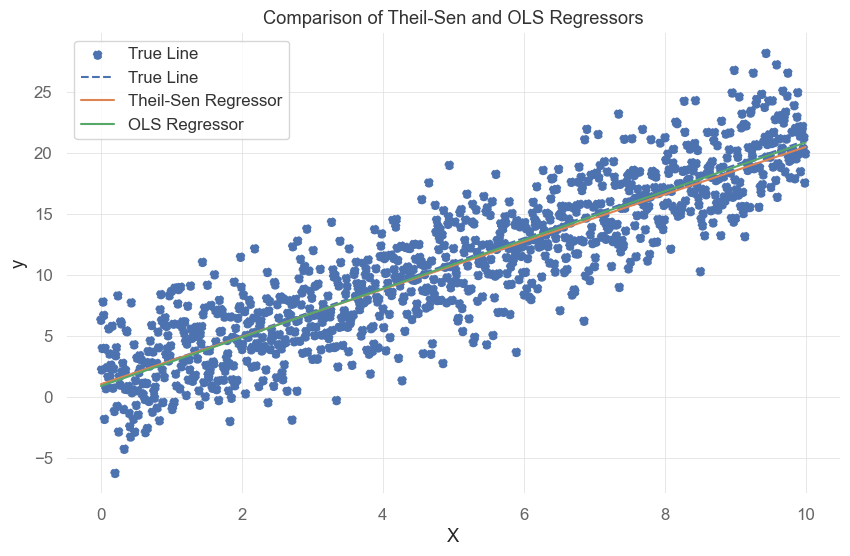

In [160]:
from sklearn.linear_model import TheilSenRegressor, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

def fit_theilsen_regressor(X: np.ndarray, y: np.ndarray, **regressor_params):
    """
    Fits a TheilSenRegressor to the data and evaluates its performance.

    The Theil-Sen estimator is a method for robust linear regression. It estimates the slope (m) as the 
    median of the slopes (yj − yi)/(xj − xi) for all pairs of sample points (xi, yi) and (xj, yj). The 
    intercept (b) is determined as the median of the values yi − mxi.

    Args:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target values.
    **regressor_params: Additional parameters to pass to the TheilSenRegressor.

    Returns:
    TheilSenRegressor: The fitted TheilSenRegressor model.
    float: The R-squared score of the fitted model.
    float: The mean absolute error of the fitted model.
    np.ndarray: The predicted values from the fitted model.
    """
    tsr = TheilSenRegressor(**regressor_params)
    tsr.fit(X, y)
    y_pred = tsr.predict(X)

    return tsr


# Generate synthetic data
np.random.seed(0)
x_vals = np.linspace(0, 10, 1000)
y_truth = 2 * x_vals + 1
y_noisy = y_truth + 3 *np.random.normal(0, 1, x_vals.shape)
X_vals = x_vals.reshape(-1, 1)

# Fit TheilSenRegressor
tsr_model = fit_theilsen_regressor(X_vals, y_noisy)
tsr_pred = tsr_model.predict(X_vals)

# Fit LinearRegression
ols = LinearRegression()
ols.fit(X_vals, y_noisy)
ols_pred = ols.predict(X_vals)

# Plotting results
plt.scatter(x_vals, y_noisy, label='True Line', linestyle='--')
plt.plot(x_vals, y_truth, label='True Line', linestyle='--')
plt.plot(x_vals, tsr_pred, label='Theil-Sen Regressor')
plt.plot(x_vals, ols_pred, label='OLS Regressor')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of Theil-Sen and OLS Regressors')
plt.show()

Theil-Sen R-squared: 0.1755710990251116
Huber R-squared: 0.19633803775381864
RANSAC R-squared: -0.07130636870968643
OLS R-squared: 0.1964259863816571


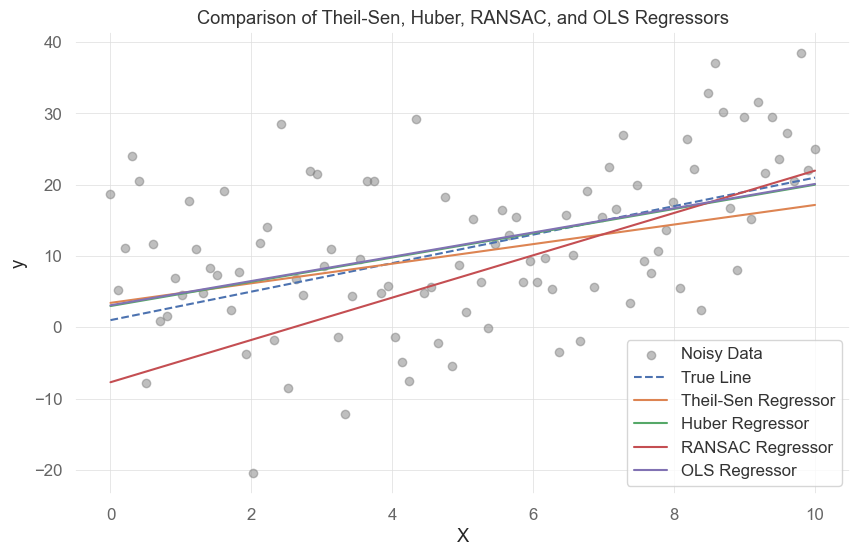

In [161]:
from sklearn.linear_model import TheilSenRegressor, LinearRegression, HuberRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import RANSACRegressor
import numpy as np
import matplotlib.pyplot as plt

def fit_theilsen_regressor(X: np.ndarray, y: np.ndarray, **regressor_params):
    """
    Fits a TheilSenRegressor to the data.

    The Theil-Sen estimator is a method for robust linear regression. It estimates the slope (m) as the 
    median of the slopes (yj − yi)/(xj − xi) for all pairs of sample points (xi, yi) and (xj, yj). The 
    intercept (b) is determined as the median of the values yi − mxi.

    Args:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target values.
    **regressor_params: Additional parameters to pass to the TheilSenRegressor.

    Returns:
    TheilSenRegressor: The fitted TheilSenRegressor model.
    """
    tsr = TheilSenRegressor(**regressor_params)
    tsr.fit(X, y)
    return tsr

def fit_huber_regressor(X: np.ndarray, y: np.ndarray, **regressor_params):
    """
    Fits a HuberRegressor to the data.

    The HuberRegressor is a method for robust linear regression. It applies a linear loss to samples that 
    are classified as outliers based on a certain threshold.

    Args:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target values.
    **regressor_params: Additional parameters to pass to the HuberRegressor.

    Returns:
    HuberRegressor: The fitted HuberRegressor model.
    """
    huber = HuberRegressor(**regressor_params)
    huber.fit(X, y)
    return huber

def fit_ransac_regressor(X: np.ndarray, y: np.ndarray, **regressor_params):
    """
    Fits a RANSACRegressor to the data.

    RANSAC (RANdom SAmple Consensus) fits a model from random subsets of inliers from the complete data set.

    Args:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target values.
    **regressor_params: Additional parameters to pass to the RANSACRegressor.

    Returns:
    RANSACRegressor: The fitted RANSACRegressor model.
    """
    ransac = RANSACRegressor(**regressor_params)
    ransac.fit(X, y)
    return ransac


# Generate synthetic data
np.random.seed(0)
x_vals = np.linspace(0, 10, 100)
y_truth = 2 * x_vals + 1
y_noisy = y_truth + 5 * np.random.normal(0, 2, x_vals.shape)
X_vals = x_vals.reshape(-1, 1)

# Fit TheilSenRegressor
tsr_model = fit_theilsen_regressor(X_vals, y_noisy)
tsr_pred = tsr_model.predict(X_vals)
tsr_r2 = r2_score(y_noisy, tsr_pred)

# Fit HuberRegressor
huber_model = fit_huber_regressor(X_vals, y_noisy)
huber_pred = huber_model.predict(X_vals)
huber_r2 = r2_score(y_noisy, huber_pred)

# Fit RANSACRegressor
ransac_model = fit_ransac_regressor(X_vals, y_noisy)
ransac_pred = ransac_model.predict(X_vals)
ransac_r2 = r2_score(y_noisy, ransac_pred)

# Fit LinearRegression (OLS)
ols = LinearRegression()
ols.fit(X_vals, y_noisy)
ols_pred = ols.predict(X_vals)
ols_r2 = r2_score(y_noisy, ols_pred)

# Print R-squared values
print(f"Theil-Sen R-squared: {tsr_r2}")
print(f"Huber R-squared: {huber_r2}")
print(f"RANSAC R-squared: {ransac_r2}")
print(f"OLS R-squared: {ols_r2}")

# Plotting results
plt.scatter(x_vals, y_noisy, label='Noisy Data', color='gray', alpha=0.5)
plt.plot(x_vals, y_truth, label='True Line', linestyle='--')
plt.plot(x_vals, tsr_pred, label='Theil-Sen Regressor')
plt.plot(x_vals, huber_pred, label='Huber Regressor')
plt.plot(x_vals, ransac_pred, label='RANSAC Regressor')
plt.plot(x_vals, ols_pred, label='OLS Regressor')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Comparison of Theil-Sen, Huber, RANSAC, and OLS Regressors')
plt.show()




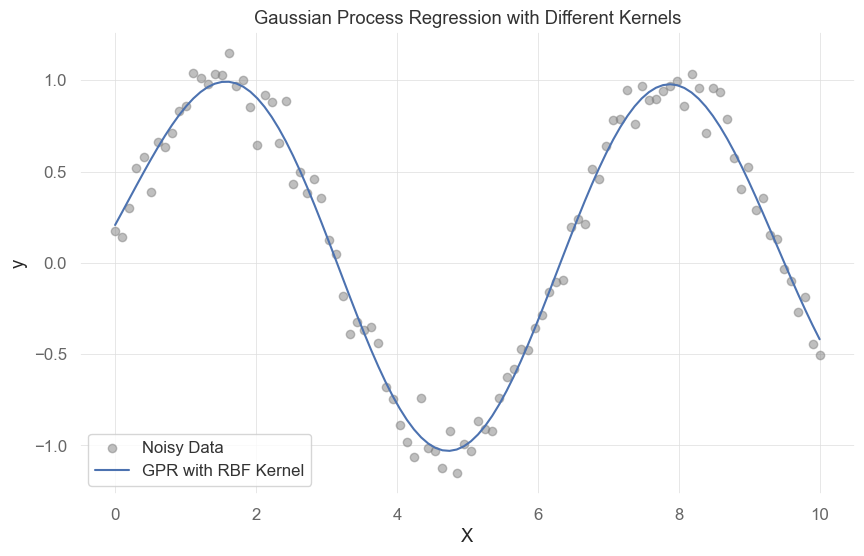

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK
import numpy as np

def create_rbf_kernel(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)):
    """
    Creates an RBF kernel.

    Args:
    length_scale (float, optional): The length scale of the RBF kernel. Defaults to 1.0.
    length_scale_bounds (tuple, optional): The bounds on the length scale. Defaults to (1e-4, 1e4).

    Returns:
    RBF: The RBF kernel.
    """
    return RBF(length_scale, length_scale_bounds)

def create_mixed_kernel(constant_value=1.0, constant_bounds=(1e-4, 1e4), length_scale=10, length_scale_bounds=(1e-4, 1e4)):
    """
    Creates a mixed kernel composed of a constant kernel and an RBF kernel.

    Args:
    constant_value (float, optional): The constant value for the constant kernel. Defaults to 1.0.
    constant_bounds (tuple, optional): The bounds on the constant value. Defaults to (1e-4, 1e4).
    length_scale (float, optional): The length scale of the RBF kernel. Defaults to 10.
    length_scale_bounds (tuple, optional): The bounds on the length scale. Defaults to (1e-4, 1e4).

    Returns:
    Product: The mixed kernel.
    """
    return CK(constant_value, constant_bounds) * RBF(length_scale, length_scale_bounds)

def fit_gaussian_process_regressor(X: np.ndarray, y: np.ndarray, alpha=1e-10, kernel=None, n_restarts_optimizer=0, normalize_y=False, **regressor_params):
    """
    Fits a GaussianProcessRegressor to the data.

    Args:
    X (np.ndarray): The input feature matrix.
    y (np.ndarray): The target values.
    alpha (float or array-like, optional): The noise level. Defaults to 1e-10.
    kernel (kernel, optional): The kernel to use. Defaults to None.
    n_restarts_optimizer (int, optional): The number of restarts for the optimizer. Defaults to 0.
    normalize_y (bool, optional): Whether to normalize the target values. Defaults to False.
    **regressor_params: Additional parameters to pass to the GaussianProcessRegressor.

    Returns:
    GaussianProcessRegressor: The fitted GaussianProcessRegressor model.
    np.ndarray: The predicted values for the input data.
    """
    gpr = GaussianProcessRegressor(alpha=alpha, kernel=kernel, n_restarts_optimizer=n_restarts_optimizer, normalize_y=normalize_y, **regressor_params)
    gpr.fit(X, y)
    predictions = gpr.predict(X)
    return gpr, predictions

# Example usage:
# Generate synthetic data
np.random.seed(0)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# Create an RBF kernel
rbf_kernel = create_rbf_kernel(length_scale=5)



# Fit the GaussianProcessRegressor with the RBF kernel
gpr_model_rbf, rbf_predictions = fit_gaussian_process_regressor(X, y, kernel=rbf_kernel, alpha=0.1, n_restarts_optimizer=10)

import matplotlib.pyplot as plt

plt.scatter(X, y, label='Noisy Data', color='gray', alpha=0.5)
plt.plot(X, rbf_predictions, label='GPR with RBF Kernel')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression with Different Kernels')
plt.show()


In [52]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y , X = raw_df.iloc[:,1], raw_df.iloc[:,2:]
X = impute_missing_values(X,strategy='median')
train_set = np.random.choice([True, False], len(y),p=[.75, .25])
# train_size = int(0.75 * len(y))
# train_set = np.zeros(len(y), dtype=bool)
# train_set[:train_size] = True
# train_set

In [29]:
# Create an RBF kernel
rbf_kernel = create_rbf_kernel(length_scale=5)
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK
mixed_kernel = kernel = CK(1.0, (1e-4, 1e4)) * RBF(20, (1e-4, 1e4))
# Fit the GaussianProcessRegressor with the RBF kernel
gpr_model_rbf, rbf_predictions = fit_gaussian_process_regressor(X[train_set],
                                                                y[train_set],
                                                                kernel=mixed_kernel,
                                                                alpha=7,
                                                                normalize_y=True,
                                                                n_restarts_optimizer=10)


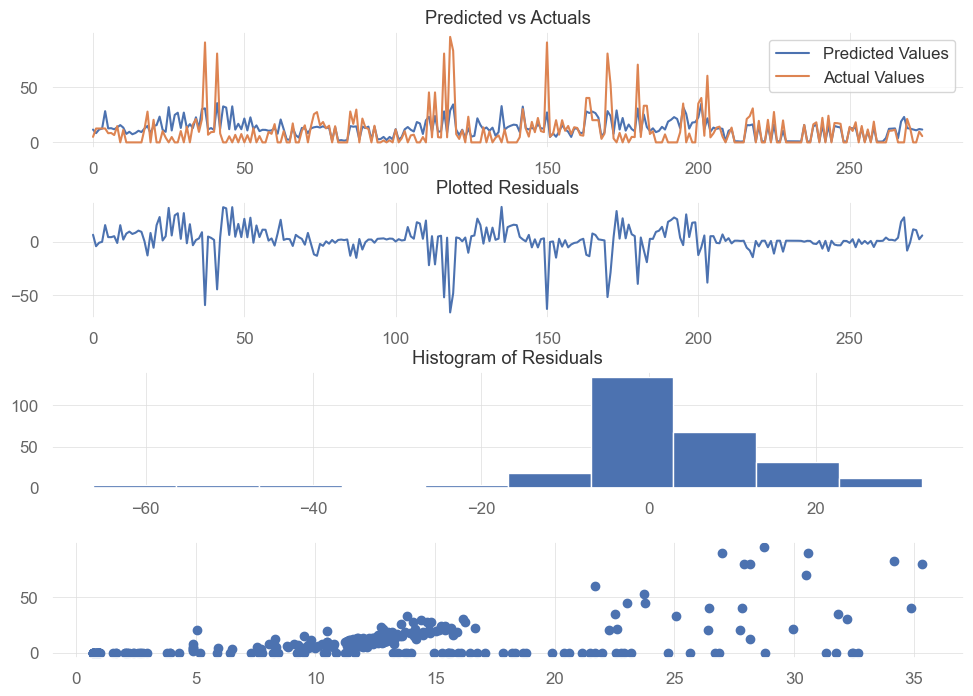

In [30]:
test_preds =   gpr_model_rbf.predict(X[~train_set])
f, ax = plt.subplots(figsize=(10, 7), nrows=4)
f.tight_layout()
ax[0].plot(range(len(test_preds)), test_preds,label='Predicted Values')
ax[0].plot(range(len(test_preds)), y[~train_set] ,label='Actual Values')
ax[0].set_title("Predicted vs Actuals")
ax[0].legend(loc='best')
ax[1].plot(range(len(test_preds)),test_preds - y[~train_set]);
ax[1].set_title("Plotted Residuals")
ax[2].hist(test_preds -y[~train_set])
ax[2].set_title("Histogram of Residuals")


ax[3].scatter(test_preds,y[~train_set])

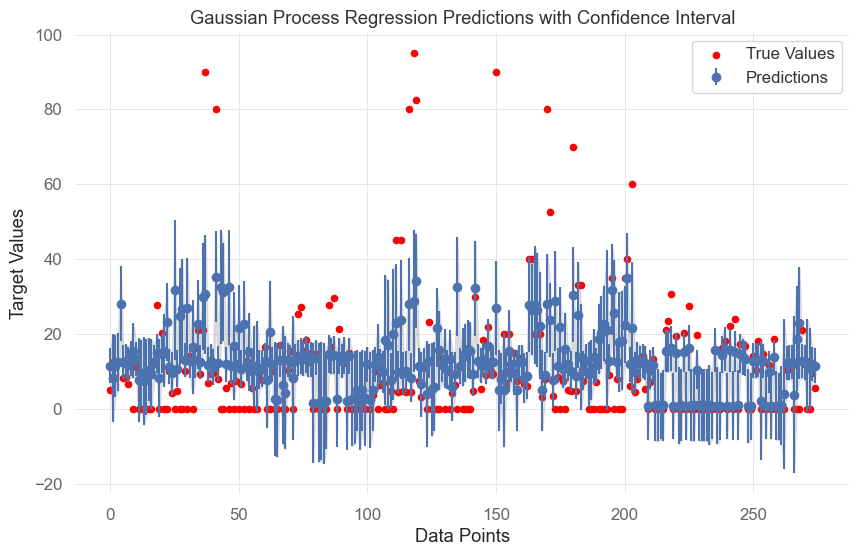

In [31]:
test_preds,sigma =   gpr_model_rbf.predict(X[~train_set],return_std=True)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(test_preds)), test_preds, yerr=1.96*sigma, fmt='o', label='Predictions')
plt.scatter(range(len(test_preds)), y[~train_set], color='red', label='True Values', s=20)
plt.fill_between(range(len(test_preds)), 
                 test_preds - 1.96*sigma, 
                 test_preds + 1.96*sigma, 
                 alpha=0.2, color='gray')
plt.xlabel("Data Points")
plt.ylabel("Target Values")
plt.legend()
plt.title("Gaussian Process Regression Predictions with Confidence Interval")
plt.show()

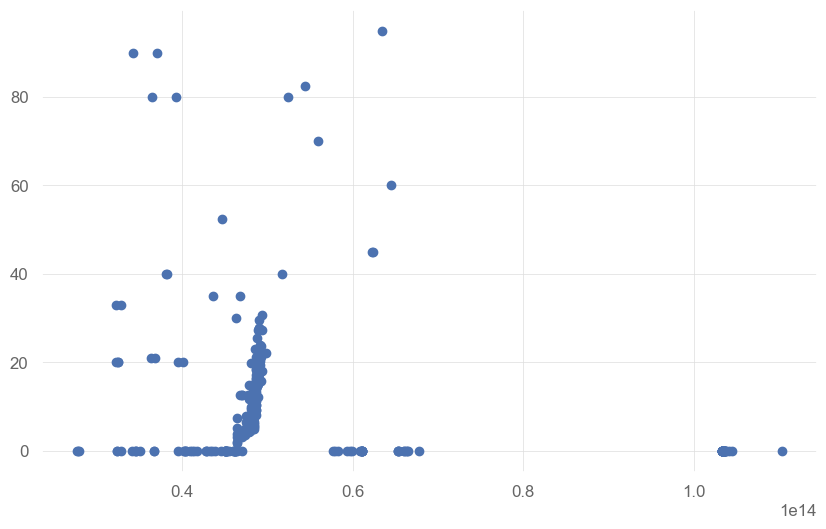

In [39]:
from sklearn.linear_model import SGDRegressor

def train_sgd_regressor(X, y, **kwargs):
    """
    Train and return an SGDRegressor model.

    Parameters:
    X (DataFrame or array-like): The input features.
    y (Series or array-like): The target values.
    **kwargs: Additional parameters for SGDRegressor.

    Returns:
    SGDRegressor: The fitted SGDRegressor model.

    Description:
    SGDRegressor is a linear model fitted by minimizing a regularized empirical loss with 
    Stochastic Gradient Descent (SGD). SGD estimates the gradient of the loss for each sample 
    and updates the model parameters iteratively. This method is particularly efficient for 
    large datasets and allows for online learning.

    The regularization term (penalty) can be set to 'l2' (default), 'l1', or 'elasticnet'. The 
    loss function can be 'squared_error' (default), 'huber', 'epsilon_insensitive', or 
    'squared_epsilon_insensitive'. Various other parameters can be adjusted, such as the 
    learning rate, maximum iterations, and tolerance for stopping criteria.

    Example usage:
    model = train_sgd_regressor(X_train, y_train, max_iter=1000, tol=1e-3, penalty='l2', 
                                random_state=42)

    Parameters for SGDRegressor include:
    - loss: str, default='squared_error'. The loss function to be used.
    - penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'. The regularization term.
    - alpha: float, default=0.0001. Constant that multiplies the regularization term.
    - l1_ratio: float, default=0.15. The Elastic Net mixing parameter.
    - fit_intercept: bool, default=True. Whether the intercept should be estimated or not.
    - max_iter: int, default=1000. The maximum number of passes over the training data.
    - tol: float or None, default=1e-3. The stopping criterion.
    - shuffle: bool, default=True. Whether or not the training data should be shuffled after each epoch.
    - verbose: int, default=0. The verbosity level.
    - epsilon: float, default=0.1. Epsilon in the epsilon-insensitive loss functions.
    - random_state: int, RandomState instance, default=None. Used for shuffling the data.
    - learning_rate: str, default='invscaling'. The learning rate schedule.
    - eta0: float, default=0.01. The initial learning rate.
    - power_t: float, default=0.25. The exponent for inverse scaling learning rate.
    - early_stopping: bool, default=False. Whether to use early stopping to terminate training.
    - validation_fraction: float, default=0.1. The proportion of training data to set aside as validation set for early stopping.
    - n_iter_no_change: int, default=5. Number of iterations with no improvement to wait before stopping fitting.
    - warm_start: bool, default=False. Reuse the solution of the previous call to fit.
    - average: bool or int, default=False. Compute the averaged SGD weights across all updates.
    """
    sgd_regressor = SGDRegressor(**kwargs)
    sgd_regressor.fit(X, y)
    return sgd_regressor

# Example usage:
model = train_sgd_regressor(X[train_set], y[train_set],
                            max_iter=1000,
                            tol=1e-4, penalty=None,
                            fit_intercept = False,
                            random_state=42)
plt.scatter(model.predict(X[~train_set]), y[~train_set])

Text(0.5, 1.0, 'After PCA')

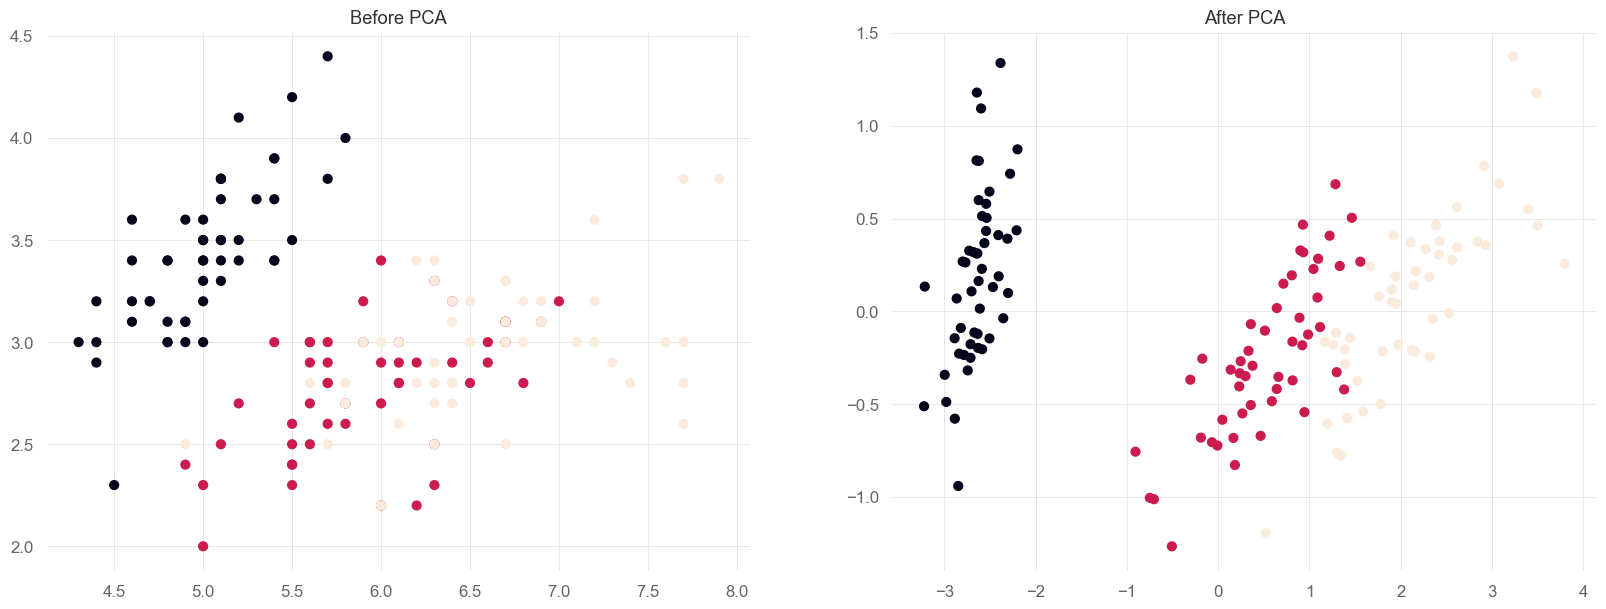

In [97]:
from sklearn import decomposition

def perform_pca(X, **kwargs):
    """
    Perform Principal Component Analysis (PCA) on the given data.

    Parameters:
    X (DataFrame or array-like): The input features.
    **kwargs: Additional parameters for PCA.

    Returns:
    tuple: A tuple containing the transformed data and the explained variance ratio.
           (transformed_data, explained_variance_ratio)

    Description:
    Principal Component Analysis (PCA) is a dimensionality reduction technique that 
    transforms the data into a new coordinate system. The new coordinates are chosen 
    such that the greatest variance by any projection of the data comes to lie on the 
    first coordinate (called the first principal component), the second greatest variance 
    on the second coordinate, and so on.

    PCA is commonly used to reduce the dimensionality of large datasets, increasing 
    interpretability while minimizing information loss. It can also be used to visualize 
    the data in 2D or 3D.

    Example usage:
    transformed_data, explained_variance_ratio = perform_pca(X, n_components=2, random_state=42)

    Parameters for PCA include:
    - n_components: int, float, None or str, default=None. Number of components to keep.
    - copy: bool, default=True. If False, data passed to fit are overwritten.
    - whiten: bool, default=False. If True, the components are multiplied by the square root of n_samples 
      and then divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.
    - svd_solver: str {'auto', 'full', 'arpack', 'randomized'}, default='auto'. The algorithm to use for the decomposition.
    - tol: float, default=0.0. Tolerance for singular values computed by svd_solver == 'arpack'.
    - iterated_power: int or 'auto', default='auto'. Number of iterations for the power method computed by svd_solver == 'randomized'.
    - random_state: int, RandomState instance or None, default=None. Used when the 'arpack' or 'randomized' solvers are used.
    """
    pca = decomposition.PCA(**kwargs)
    pca.fit(X)
    return pca
  
from sklearn import datasets
iris = datasets.load_iris()
iris_X = pd.DataFrame(iris.data)
y = pd.DataFrame(iris.target)


pca = perform_pca(scale_features(iris_X),n_components = 2)
pca.explained_variance_ratio_.sum()
iris_X_prime = pd.DataFrame(pca.fit_transform(iris_X))



fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
ax.scatter(iris_X.iloc[:,0],iris_X.iloc[:,1],c=y,s=40)
ax.set_title('Before PCA')
ax2 = fig.add_subplot(122)
ax2.scatter(iris_X_prime.iloc[:,0],iris_X_prime.iloc[:,1],c=y,s=40)
ax2.set_title('After PCA')


In [98]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()),('pca',decomposition.PCA(n_components=2))])
pipe.fit_transform(iris_X)

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538],
       [-2.07563095,  1.48917752],
       [-2.44402884,  0.0476442 ],
       [-2.23284716,  0.22314807],
       [-2.33464048, -1.11532768],
       [-2.18432817, -0.46901356],
       [-2.1663101 ,  1.04369065],
       [-2.32613087,  0.13307834],
       [-2.2184509 , -0.72867617],
       [-2.6331007 , -0.96150673],
       [-2.1987406 ,  1.86005711],
       [-2.26221453,  2.68628449],
       [-2.2075877 ,  1.48360936],
       [-2.19034951,  0.48883832],
       [-1.898572  ,  1.40501879],
       [-2.34336905,  1.12784938],
       [-1.914323  ,  0.40885571],
       [-2.20701284,  0.92412143],
       [-2.7743447 ,  0.45834367],
       [-1.81866953,  0.08555853],
       [-2.22716331,  0.13725446],
       [-1.95184633, -0.62561859],
       [-2.05115137,  0.24216355],
       [-2.16857717,  0.52714953],
       [-2.13956345,

Text(0.5, 1.0, 'FactorAnalysis')

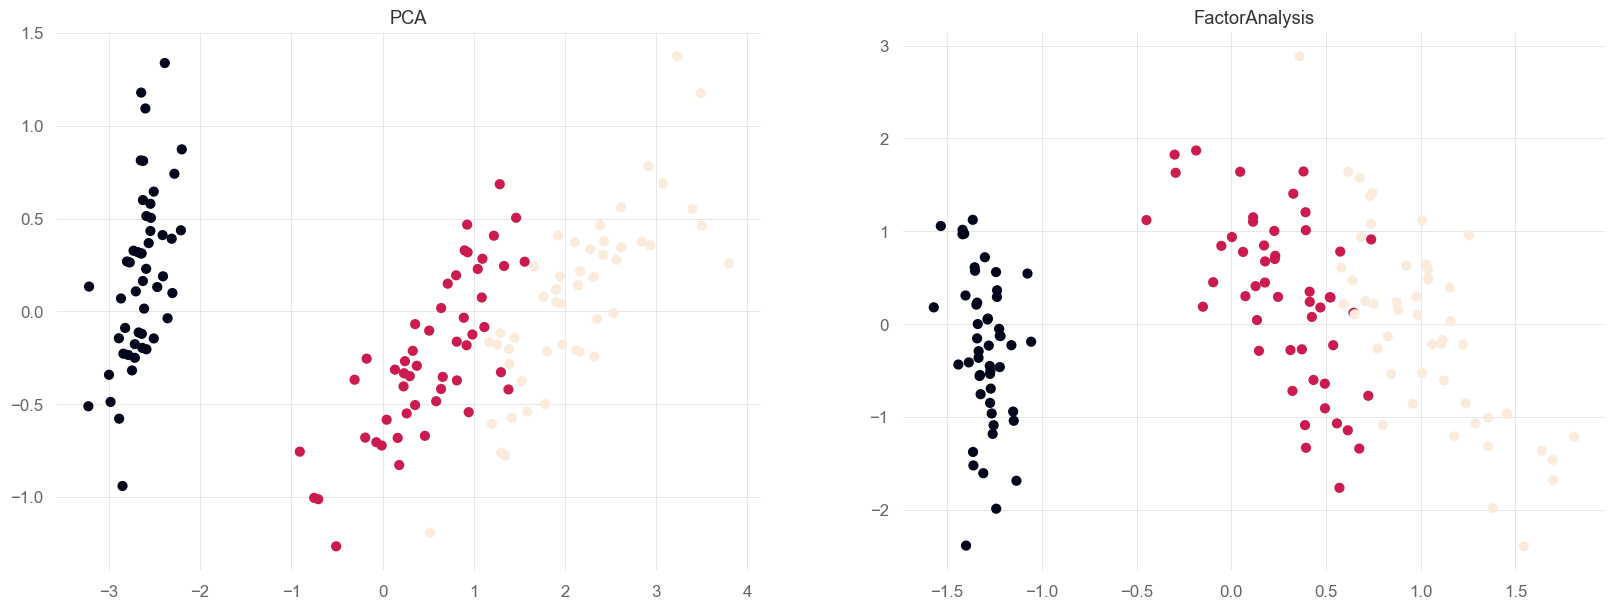

In [99]:
from sklearn.decomposition import FactorAnalysis

def perform_factor_analysis(X, **kwargs):
    """
    Perform Factor Analysis (FA) on the given data.

    Parameters:
    X (DataFrame or array-like): The input features.
    **kwargs: Additional parameters for FactorAnalysis.

    Returns:
    ndarray: The transformed data after applying factor analysis.
    
    Description:
    Factor Analysis (FA) is a simple linear generative model with Gaussian latent variables.
    The observations are assumed to be caused by a linear transformation of lower-dimensional
    latent factors and added Gaussian noise. Without loss of generality, the factors are 
    distributed according to a Gaussian with zero mean and unit covariance. The noise is also 
    zero mean and has an arbitrary diagonal covariance matrix.

    If the Gaussian noise is isotropic (all diagonal entries are the same), PCA can be obtained 
    as a special case of FA. FactorAnalysis performs a maximum likelihood estimate of the 
    loading matrix, the transformation of the latent variables to the observed ones, using an 
    SVD-based approach.

    Example usage:
    transformed_data = perform_factor_analysis(X, n_components=2, random_state=42)

    Parameters for FactorAnalysis include:
    - n_components: int, default=None. Dimensionality of latent space.
    - tol: float, default=0.01. Stopping tolerance for log-likelihood increase.
    - copy: bool, default=True. Whether to make a copy of X.
    - max_iter: int, default=1000. Maximum number of iterations.
    - noise_variance_init: array-like of shape (n_features,), default=None. Initial guess of the noise variance.
    - svd_method: {'lapack', 'randomized'}, default='randomized'. SVD method to use.
    - iterated_power: int, default=3. Number of iterations for the power method.
    - rotation: {'varimax', 'quartimax'}, default=None. Apply rotation if not None.
    - random_state: int or RandomState instance, default=0. For reproducible results when using 'randomized' SVD method.
    """
    fa = FactorAnalysis(**kwargs)
    transformed_data = fa.fit_transform(X)
    return transformed_data

# Example usage:
iris_two_dim = perform_factor_analysis(scale_features(iris_X), n_components=2, random_state=42)
iris_two_dim = pd.DataFrame(iris_two_dim)
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
ax.scatter(iris_X_prime.iloc[:,0],iris_X_prime.iloc[:,1],c=y,s=40)
ax.set_title('PCA')
ax2 = fig.add_subplot(122)
ax2.scatter(iris_two_dim.iloc[:,0],iris_two_dim.iloc[:,1],c=y,s=40)
ax2.set_title('FactorAnalysis')


Text(0.5, 1.0, 'kernelPCA')

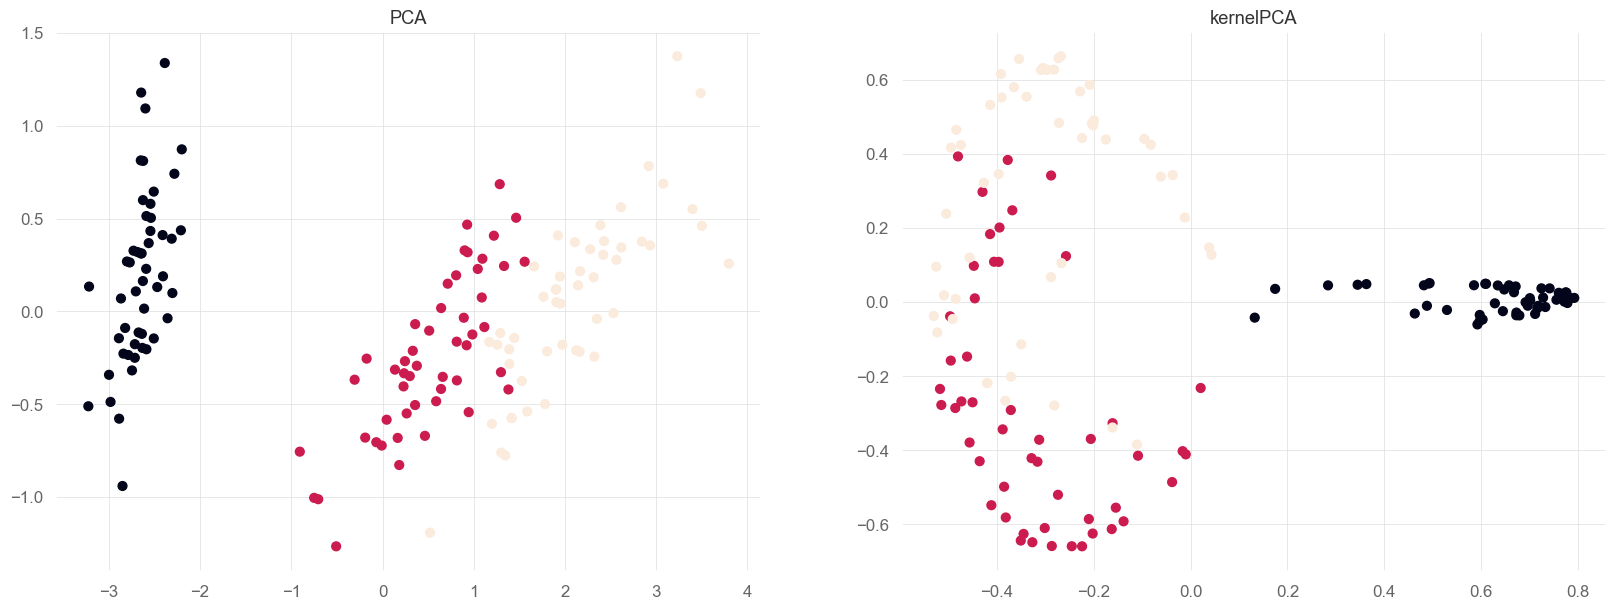

In [113]:
from sklearn.decomposition import KernelPCA

def perform_kernel_pca(X, **kwargs):
    """
    Perform Kernel Principal Component Analysis (KPCA) on the given data.

    Parameters:
    X (DataFrame or array-like): The input features.
    **kwargs: Additional parameters for KernelPCA.

    Returns:
    ndarray: The transformed data after applying kernel PCA.

    Description:
    Kernel Principal Component Analysis (KPCA) is a non-linear dimensionality reduction 
    technique that uses kernel methods to project data into a higher-dimensional space 
    where linear separation is possible. It is particularly useful for capturing non-linear 
    relationships in the data.

    KPCA can use various kernels such as linear, polynomial, radial basis function (rbf), 
    sigmoid, and cosine. Depending on the kernel chosen, KPCA can capture different types 
    of relationships within the data.

    Example usage:
    transformed_data = perform_kernel_pca(X, n_components=2, kernel='rbf', gamma=0.1, random_state=42)

    Parameters for KernelPCA include:
    - n_components: int, default=None. Number of components to keep.
    - kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed'} or callable, default='linear'. Kernel to use.
    - gamma: float, default=None. Kernel coefficient for rbf, poly, and sigmoid kernels.
    - degree: float, default=3. Degree for poly kernels.
    - coef0: float, default=1. Independent term in poly and sigmoid kernels.
    - kernel_params: dict, default=None. Parameters for kernel as callable object.
    - alpha: float, default=1.0. Hyperparameter for ridge regression when fit_inverse_transform=True.
    - fit_inverse_transform: bool, default=False. Learn the inverse transform for non-precomputed kernels.
    - eigen_solver: {'auto', 'dense', 'arpack', 'randomized'}, default='auto'. Select eigensolver to use.
    - tol: float, default=0. Convergence tolerance for arpack.
    - max_iter: int, default=None. Maximum number of iterations for arpack.
    - iterated_power: int >= 0, or 'auto', default='auto'. Number of iterations for the power method.
    - remove_zero_eig: bool, default=False. Remove components with zero eigenvalues.
    - random_state: int or RandomState instance, default=None. For reproducible results when using 'arpack' or 'randomized' eigen_solver.
    - copy_X: bool, default=True. If True, input X is copied and stored by the model.
    - n_jobs: int, default=None. Number of parallel jobs to run.

    Reference:
    - For more details and advanced usage, refer to the scikit-learn User Guide.
    """
    kpca = KernelPCA(**kwargs)
    transformed_data = kpca.fit_transform(X)
    return transformed_data


iris_kernel_pca = perform_kernel_pca(scale_features(iris_X), n_components=2, kernel='rbf',
                                     gamma=0.5, random_state=42)
iris_kernel_pca = pd.DataFrame(iris_kernel_pca)
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(121)
ax.scatter(iris_X_prime.iloc[:,0],iris_X_prime.iloc[:,1],c=y,s=40)
ax.set_title('PCA')
ax2 = fig.add_subplot(122)
ax2.scatter(iris_kernel_pca.iloc[:,0],iris_kernel_pca.iloc[:,1],c=y,s=40)
ax2.set_title('kernelPCA')


## Inspection

Common pitfalls in the interpretation of coefficients of linear models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

In [3]:
import ssl
import urllib.request
from sklearn.datasets import fetch_openml

# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context
survey = fetch_openml(data_id=534, as_frame=True)
X = survey.data[survey.feature_names]
X.describe(include="all")

c:\Users\marti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
count,534.000000,534,534,534.000000,534,534.000000,534,534,534,534
unique,NaN,2,2,NaN,2,NaN,3,6,3,2
top,NaN,no,male,NaN,not_member,NaN,White,Other,Other,Married
freq,NaN,378,289,NaN,438,NaN,440,156,411,350
mean,13.018727,NaN,NaN,17.822097,NaN,36.833333,NaN,NaN,NaN,NaN
std,2.615373,NaN,NaN,12.379710,NaN,11.726573,NaN,NaN,NaN,NaN
min,2.000000,NaN,NaN,0.000000,NaN,18.000000,NaN,NaN,NaN,NaN
25%,12.000000,NaN,NaN,8.000000,NaN,28.000000,NaN,NaN,NaN,NaN
50%,12.000000,NaN,NaN,15.000000,NaN,35.000000,NaN,NaN,NaN,NaN
75%,15.000000,NaN,NaN,26.000000,NaN,44.000000,NaN,NaN,NaN,NaN


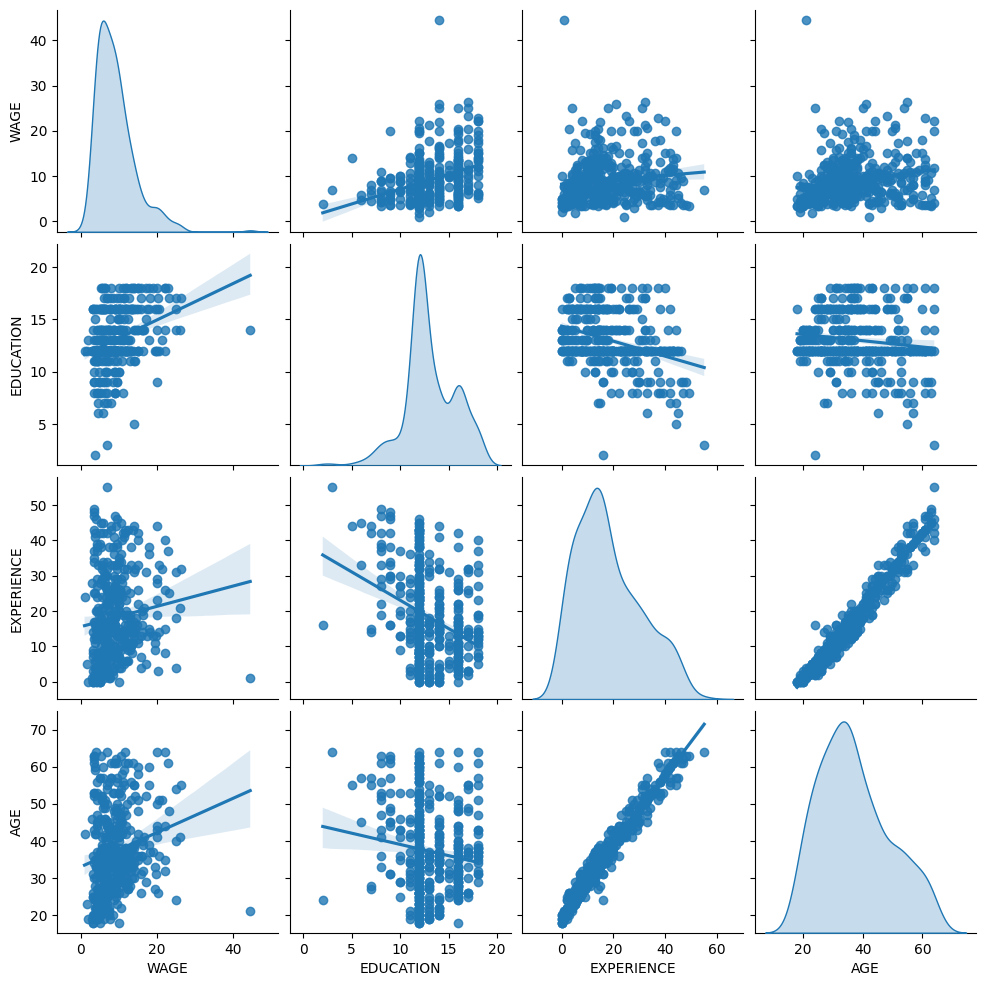

In [6]:
from sklearn.model_selection import train_test_split
y = survey.target.values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
train_dataset = X_train.copy()
train_dataset.insert(0, "WAGE", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

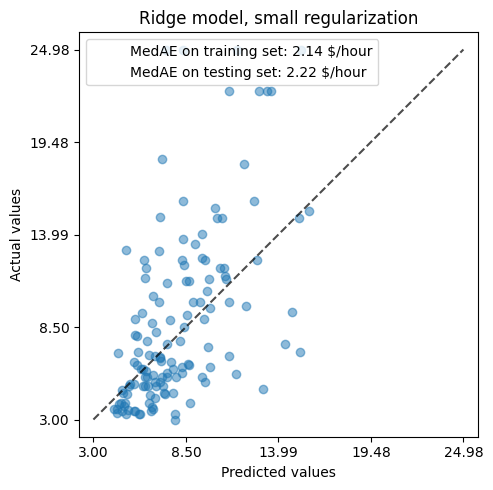

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns = ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model.fit(X_train, y_train)

from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f} $/hour",
    "MedAE on testing set": f"{mae_test:.2f} $/hour",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Ridge model, small regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()



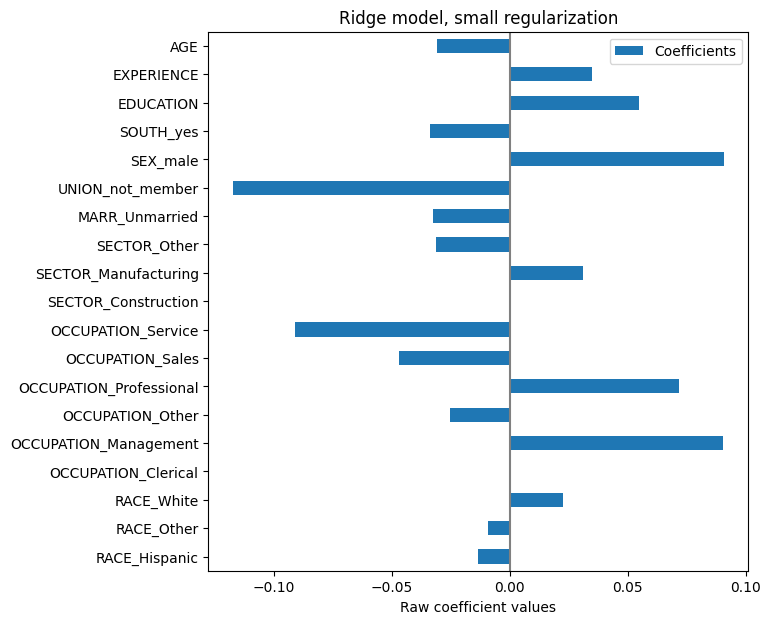

In [18]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

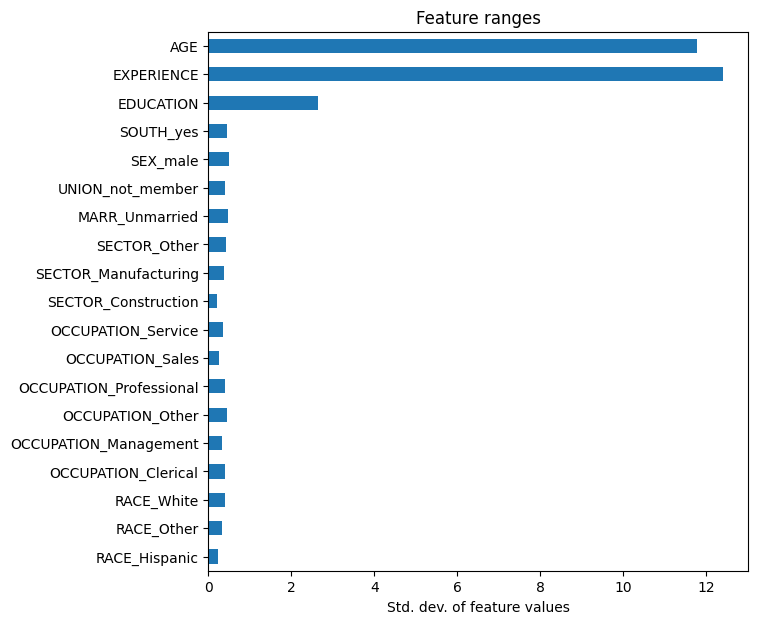

In [19]:
X_train_preprocessed = pd.DataFrame(
    model[:-1].transform(X_train), columns=feature_names
)

X_train_preprocessed.std(axis=0).plot.barh(figsize=(9, 7))
plt.title("Feature ranges")
plt.xlabel("Std. dev. of feature values")
plt.subplots_adjust(left=0.3)

In [ ]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_ * X_train_preprocessed.std(axis=0),
    columns=["Coefficient importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(9, 7))
plt.xlabel("Coefficient values corrected by the feature's std. dev.")
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)